In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

# **Step 1: Data Preprocessing**
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/"

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])

def parse_emotion_from_filename(filename):
    parts = filename.split('-')
    emotion_code = int(parts[2])  # Extract emotion code
    return emotion_code - 1  # Map to zero-based index

def generate_confidence(label):
    confidence_map = {0: 0.9, 1: 0.8, 2: 0.85, 3: 0.7, 4: 0.95, 5: 0.75, 6: 0.88, 7: 0.92}
    return confidence_map.get(label, 0.8)

data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                label = parse_emotion_from_filename(file)
                confidence = generate_confidence(label)
                data.append((features, label, confidence))

features_df = pd.DataFrame(data, columns=["features", "label", "confidence"])

X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())
confidence = np.array(features_df["confidence"].tolist())

num_classes = 8
assert np.all((y >= 0) & (y < num_classes)), "Labels must be in range [0, 7]"

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp, conf_train, conf_temp = train_test_split(
    X, y, confidence, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, conf_val, conf_test = train_test_split(
    X_temp, y_temp, conf_temp, test_size=0.5, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

conf_train = conf_train.reshape(-1, 1)
conf_val = conf_val.reshape(-1, 1)
conf_test = conf_test.reshape(-1, 1)

# **Step 2: Model Definition**
def build_transformer_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking()(inputs)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.LSTM(128)(x)
    emotion_output = layers.Dense(num_classes, activation="softmax", name="emotion_output")(x)
    confidence_output = layers.Dense(1, activation="sigmoid", name="confidence_output")(x)
    return models.Model(inputs, [emotion_output, confidence_output])

model = build_transformer_lstm((X_train.shape[1], 1), num_classes)

model.compile(
    optimizer="adam",
    loss={"emotion_output": "sparse_categorical_crossentropy", "confidence_output": "mse"},
    metrics={"emotion_output": "accuracy"}
)

model.summary()

# **Step 3: Verify Before Training**
sample_input = X_train[:2]
sample_output = model.predict(sample_input)
print("Sample output shape (emotion):", sample_output[0].shape)
print("Sample output shape (confidence):", sample_output[1].shape)

# **Step 4: Train the Model**
history = model.fit(
    X_train, {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32
)

# **Step 5: Evaluate the Model**
test_loss, test_metrics = model.evaluate(
    X_test, {"emotion_output": y_test, "confidence_output": conf_test}
)

print(f"Emotion Test Accuracy: {test_metrics[1] * 100:.2f}%")
print(f"Confidence Test MSE: {test_loss[1]:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_1 (Masking)           │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_1 (Any)                   │ (None, 59)                │               0 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 59, 1)             │             897 │ masking_1[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ masking_1[0][0],           │
│                               │                           │                 │ any_1[0][0], any_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 59, 1)             │               2 │ multi_head_attention_1[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 59, 64)            │             128 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 128)               │          98,816 │ dense_1[0][0], any_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emotion_output (Dense)        │ (None, 8)                 │           1,032 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ confidence_output (Dense)     │ (None, 1)                 │             129 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 101,004 (394.55 KB)

 Trainable params: 101,004 (394.55 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Sample output shape (emotion): (2, 8)
Sample output shape (confidence): (2, 1)
Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\140095176.py", line 95, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 6 3 7 1 0 2 1 2 1 4 6 1 3 2 2 3 0 6 6 0 3 5 2 3 3 3 3 2 4 0 1 6
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_11815]

In [3]:
print("Unique labels in dataset:", np.unique(y_train))
assert np.all((y_train >= 0) & (y_train < num_classes)), "Labels must be in range [0, 7]"


Unique labels in dataset: [0 1 2 3 4 5 6 7]


In [4]:
# Validate labels
print("Unique labels in training data:", np.unique(y_train))
print("Unique labels in validation data:", np.unique(y_val))
print("Unique labels in test data:", np.unique(y_test))

assert np.all((y_train >= 0) & (y_train < num_classes)), "Train labels out of range [0, 7]"
assert np.all((y_val >= 0) & (y_val < num_classes)), "Validation labels out of range [0, 7]"
assert np.all((y_test >= 0) & (y_test < num_classes)), "Test labels out of range [0, 7]"

# Confirm model output compatibility
sample_input = X_train[:2]
sample_output = model.predict(sample_input)
print("Sample output shape (emotion):", sample_output[0].shape)  # Expect (2, 8)
print("Sample output shape (confidence):", sample_output[1].shape)  # Expect (2, 1)

# Train the model
history = model.fit(
    X_train, 
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_metrics = model.evaluate(
    X_test, 
    {"emotion_output": y_test, "confidence_output": conf_test}
)
print(f"Emotion Test Accuracy: {test_metrics[1] * 100:.2f}%")
print(f"Confidence Test MSE: {test_loss[1]:.4f}")


Unique labels in training data: [0 1 2 3 4 5 6 7]
Unique labels in validation data: [0 1 2 3 4 5 6 7]
Unique labels in test data: [0 1 2 3 4 5 6 7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Sample output shape (emotion): (2, 8)
Sample output shape (confidence): (2, 1)
Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\140095176.py", line 95, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 5 4 7 4 0 6 3 2 1 3 5 4 7 3 5 3 6 3 3 7 7 1 5 2 2 6 5 5 4 0 4 3
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_11815]

In [6]:
# Define Model
input_layer = tf.keras.layers.Input(shape=(59, 1), name="input_layer")
x = tf.keras.layers.Masking(mask_value=0)(input_layer)
x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=1)(x, x)
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
lstm_output = tf.keras.layers.LSTM(128)(x)

# Emotion detection output
emotion_output = tf.keras.layers.Dense(8, activation="softmax", name="emotion_output")(lstm_output)

# Confidence level output
confidence_output = tf.keras.layers.Dense(1, activation="linear", name="confidence_output")(lstm_output)

model = tf.keras.Model(inputs=input_layer, outputs=[emotion_output, confidence_output])

# Compile model
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        "confidence_output": tf.keras.losses.MeanSquaredError()
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)

# Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_2 (NotEqual)        │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_2 (Masking)           │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_2 (Any)                   │ (None, 59)                │               0 │ not_equal_2[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 59, 1)             │              15 │ masking_2[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ masking_2[0][0],           │
│                               │                           │                 │ any_2[0][0], any_2[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 59, 1)             │               2 │ multi_head_attention_2[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 59, 64)            │             128 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 128)               │          98,816 │ dense_2[0][0], any_2[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emotion_output (Dense)        │ (None, 8)                 │           1,032 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ confidence_output (Dense)     │ (None, 1)                 │             129 │ lstm_2[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,122 (391.10 KB)

 Trainable params: 100,122 (391.10 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train,
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\3879632540.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 6 4 1 4 5 6 7 6 3 5 6 0 6 1 7 5 1 2 3 3 2 2 4 1 5 1 5 2 2 7 7 7
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_17794]

In [8]:
# Define the model
input_layer = tf.keras.layers.Input(shape=(59, 1), name="input_layer")
x = tf.keras.layers.Masking(mask_value=0)(input_layer)
x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=1)(x, x)
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
lstm_output = tf.keras.layers.LSTM(128)(x)

# Output layers
emotion_output = tf.keras.layers.Dense(8, activation="softmax", name="emotion_output")(lstm_output)
confidence_output = tf.keras.layers.Dense(1, activation="linear", name="confidence_output")(lstm_output)

# Build the model
model = tf.keras.Model(inputs=input_layer, outputs=[emotion_output, confidence_output])

# Compile the model
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        "confidence_output": tf.keras.losses.MeanSquaredError()
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)

# Verify the labels
print("Unique labels in training data:", np.unique(y_train))
print("Unique labels in validation data:", np.unique(y_val))
print("Unique labels in test data:", np.unique(y_test))

# Train the model
history = model.fit(
    X_train,
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)


Unique labels in training data: [0 1 2 3 4 5 6 7]
Unique labels in validation data: [0 1 2 3 4 5 6 7]
Unique labels in test data: [0 1 2 3 4 5 6 7]
Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\1381722360.py", line 35, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 7 3 1 2 0 4 4 1 5 3 3 7 4 3 1 4 4 6 4 4 1 5 1 5 1 5 4 6 5 2 6 4
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_23651]

In [9]:
assert np.all(y_train >= 0) and np.all(y_train < 8)
assert np.all(y_val >= 0) and np.all(y_val < 8)
assert np.all(y_test >= 0) and np.all(y_test < 8)


In [10]:
preds = model.predict(X_train[:5])
print("Emotion output shape:", preds[0].shape)
print("Confidence output shape:", preds[1].shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Emotion output shape: (5, 8)
Confidence output shape: (5, 1)


In [11]:
print("Sample emotion labels (y_train):", y_train[:10])
print("Sample confidence labels (conf_train):", conf_train[:10])
print("Unique emotion labels:", np.unique(y_train))


Sample emotion labels (y_train): [5 3 2 5 6 2 5 5 4 7]
Sample confidence labels (conf_train): [[0.75]
 [0.7 ]
 [0.85]
 [0.75]
 [0.88]
 [0.85]
 [0.75]
 [0.75]
 [0.95]
 [0.92]]
Unique emotion labels: [0 1 2 3 4 5 6 7]


In [13]:
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mean_squared_error"
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)


In [14]:
history = model.fit(
    X_train,
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\3879632540.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 0 2 6 6 7 4 4 3 3 2 3 3 4 5 5 5 1 2 1 3 4 5 3 7 4 7 6 3 6 7 4 7
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_29708]

In [15]:
print("Unique labels in training data:", np.unique(y_train))
print("Unique labels in validation data:", np.unique(y_val))
print("Unique labels in test data:", np.unique(y_test))


Unique labels in training data: [0 1 2 3 4 5 6 7]
Unique labels in validation data: [0 1 2 3 4 5 6 7]
Unique labels in test data: [0 1 2 3 4 5 6 7]


In [16]:
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mean_squared_error"
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)


In [17]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)


Shape of y_train: (1008,)
Shape of y_val: (216,)
Shape of y_test: (216,)


In [18]:
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2 3 4 5 6 7]
Unique labels in y_val: [0 1 2 3 4 5 6 7]
Unique labels in y_test: [0 1 2 3 4 5 6 7]


In [19]:
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mean_squared_error"
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)


In [20]:
sample_output = model.predict(X_train[:5])
print("Emotion output shape:", sample_output[0].shape)  # Expected: (5, 8)
print("Confidence output shape:", sample_output[1].shape)  # Expected: (5, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
Emotion output shape: (5, 8)
Confidence output shape: (5, 1)


In [21]:
y_train = np.clip(y_train, 0, 7).astype(int)
y_val = np.clip(y_val, 0, 7).astype(int)
y_test = np.clip(y_test, 0, 7).astype(int)


In [22]:
y_train = np.argmax(y_train, axis=-1) if y_train.ndim > 1 else y_train
y_val = np.argmax(y_val, axis=-1) if y_val.ndim > 1 else y_val
y_test = np.argmax(y_test, axis=-1) if y_test.ndim > 1 else y_test


In [23]:
history = model.fit(
    X_train,
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\3879632540.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 7 4 5 5 1 1 2 0 1 2 1 1 1 3 3 0 2 5 4 0 6 1 3 4 7 0 6 7 2 7 4 1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_35710]

In [24]:
import numpy as np

print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
print("Unique labels in y_test:", np.unique(y_test))


Unique labels in y_train: [0 1 2 3 4 5 6 7]
Unique labels in y_val: [0 1 2 3 4 5 6 7]
Unique labels in y_test: [0 1 2 3 4 5 6 7]


In [25]:
y_train = np.clip(y_train, 0, 7).astype(int)
y_val = np.clip(y_val, 0, 7).astype(int)
y_test = np.clip(y_test, 0, 7).astype(int)


In [26]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_3 (NotEqual)        │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_3 (Masking)           │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_3 (Any)                   │ (None, 59)                │               0 │ not_equal_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 59, 1)             │              15 │ masking_3[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ masking_3[0][0],           │
│                               │                           │                 │ any_3[0][0], any_3[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 59, 1)             │               2 │ multi_head_attention_3[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 59, 64)            │             128 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 128)               │          98,816 │ dense_3[0][0], any_3[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emotion_output (Dense)        │ (None, 8)                 │           1,032 │ lstm_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ confidence_output (Dense)     │ (None, 1)                 │             129 │ lstm_3[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 300,368 (1.15 MB)

 Trainable params: 100,122 (391.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 200,246 (782.21 KB)

In [27]:
y_train = np.clip(y_train, 0, 7).astype(int)
y_val = np.clip(y_val, 0, 7).astype(int)
y_test = np.clip(y_test, 0, 7).astype(int)


In [28]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of conf_train:", conf_train.shape)


Shape of X_train: (1008, 59, 1)
Shape of y_train: (1008,)
Shape of conf_train: (1008, 1)


In [29]:
sample_output = model.predict(X_train[:5])
print("Emotion output shape:", sample_output[0].shape)  # Expect (5, 8)
print("Confidence output shape:", sample_output[1].shape)  # Expect (5, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Emotion output shape: (5, 8)
Confidence output shape: (5, 1)


In [30]:
model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mean_squared_error"
    },
    metrics={
        "emotion_output": "accuracy",
        "confidence_output": "mse"
    }
)


In [31]:
history = model.fit(
    X_train,
    {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_14424\3879632540.py", line 1, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 1 3 3 5 4 3 2 4 6 4 2 3 1 0 2 7 6 4 4 3 2 5 5 5 6 3 5 1 4 2 0 2
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_41403]

In [1]:
import os
import librosa
import numpy as np
import pandas as pd

# Correct path to dataset
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/"

# Preprocess audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])

# Parse metadata from filenames
def parse_emotion_from_filename(filename):
    # Assuming RAVDESS naming conventions
    parts = filename.split('-')
    emotion_code = parts[2]  # Extract emotion code
    return int(emotion_code)

# Process all files
data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):  # Process only .wav files
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                label = parse_emotion_from_filename(file)  # Extract emotion label
                data.append((features, label))

# Create DataFrame
features_df = pd.DataFrame(data, columns=["features", "label"])


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert features and labels into arrays
X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [3]:
# Check features_df
print(features_df.head())
print(features_df.shape)

# Convert features to array
X = np.array(features_df["features"].tolist())
if X.size == 0:  # Handle empty features
    raise ValueError("Feature extraction failed. Check your dataset and preprocessing.")

# Ensure X is 2D
if len(X.shape) == 1:
    X = np.expand_dims(X, axis=1)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Proceed with train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Empty DataFrame
Columns: [features, label]
Index: []
(0, 2)


ValueError: Feature extraction failed. Check your dataset and preprocessing.

In [4]:
import os

DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/"
print("Subfolders in DATA_PATH:")
print(os.listdir(DATA_PATH))  # List subfolders in the dataset directory

for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path):
        print(f"Files in {folder}:")
        print(os.listdir(folder_path))  # List files in each subfolder


Subfolders in DATA_PATH:
['Dataset_Link.txt', 'Giggle_Function_2']
Files in Giggle_Function_2:
['.git', '.ipynb_checkpoints', 'Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'archive (11).zip', 'audio_speech_actors_01-24', 'Untitled.ipynb', 'Untitled1.ipynb']


In [5]:
import os
import librosa
import numpy as np
import pandas as pd

# Update DATA_PATH to point to the correct folder
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/"

# Preprocess audio files
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Parse metadata from filenames
def parse_emotion_from_filename(filename):
    parts = filename.split('-')
    return int(parts[2])  # Assuming RAVDESS naming conventions

# Process all actor folders
data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):  # Process only .wav files
                file_path = os.path.join(folder_path, file)
                print(f"Processing {file_path}")
                features = extract_features(file_path)
                if features is not None:  # Only include valid features
                    label = parse_emotion_from_filename(file)
                    data.append((features, label))

# Create a DataFrame
features_df = pd.DataFrame(data, columns=["features", "label"])

# Verify the DataFrame
print(features_df.head())
print(features_df.shape)


Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-01-01-01-01-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-01-01-01-02-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-01-01-02-01-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-01-01-02-02-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-02-01-01-01-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-02-01-01-02-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-02-01-02-01-01.wav
Processing C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/Actor_01\03-01-02-01-02-02-01.wav
Processing C:/Users/admin/Desktop/Voice 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert features and labels into arrays
X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (1008, 59, 1), (1008,)
Validation data shape: (216, 59, 1), (216,)
Test data shape: (216, 59, 1), (216,)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Transformer-LSTM Model
def build_transformer_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking()(inputs)

    # Transformer Encoder
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)

    # LSTM
    x = layers.LSTM(128, return_sequences=False)(x)

    # Output layer for emotion classification
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
num_classes = len(np.unique(y))  # Number of unique emotion labels
input_shape = (X_train.shape[1], 1)
model = build_transformer_lstm(input_shape, num_classes)

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 59)                │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 59, 1)             │             897 │ masking[0][0],             │
│ (MultiHeadAttention)          │                           │                 │ masking[0][0], any[0][0],  │
│                               │                           │                 │ any[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 59, 1)             │               2 │ multi_head_attention[0][0] │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 59, 64)            │             128 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 128)               │          98,816 │ dense[0][0], any[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 8)                 │           1,032 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,875 (394.04 KB)

 Trainable params: 100,875 (394.04 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/30


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_4760\3072454354.py", line 2, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 8 which is outside the valid range of [0, 8).  Label values: 8 2 5 8 6 6 1 1 4 1 6 7 8 6 5 6 2 3 8 3 5 4 4 2 4 8 2 5 6 2 4 5
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_5112]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_1 (Masking)           │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_1 (Any)                   │ (None, 59)                │               0 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 59, 1)             │             897 │ masking_1[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ masking_1[0][0],           │
│                               │                           │                 │ any_1[0][0], any_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 59, 1)             │               2 │ multi_head_attention_1[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 59, 64)            │             128 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 128)               │          98,816 │ dense_2[0][0], any_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 8)                 │           1,032 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,875 (394.04 KB)

 Trainable params: 100,875 (394.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.1207 - loss: 2.0778 - val_accuracy: 0.1157 - val_loss: 2.0533
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1464 - loss: 2.0643 - val_accuracy: 0.1157 - val_loss: 2.0603
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1464 - loss: 2.0648 - val_accuracy: 0.1157 - val_loss: 2.0526
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1453 - loss: 2.0646 - val_accuracy: 0.1157 - val_loss: 2.0514
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1372 - loss: 2.0586 - val_accuracy: 0.1157 - val_loss: 2.0554
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1581 - loss: 2.0639 - val_accuracy: 0.1157 - val_loss: 2.0516
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1613 - loss: 2.0616 - val_accuracy: 0.1157 - val_loss: 2.0548
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1329 - loss: 2.0640 - val_accuracy: 0.1157 - val_loss: 2

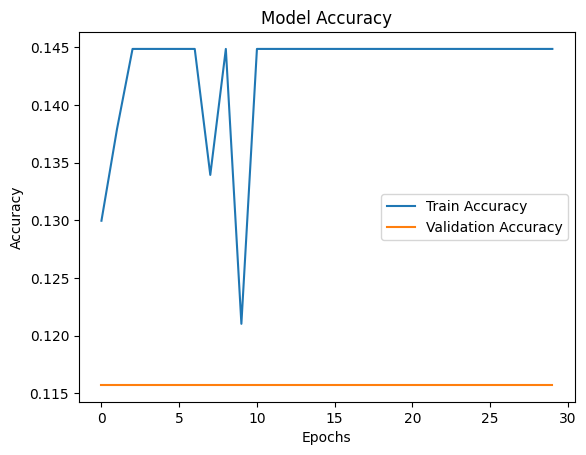

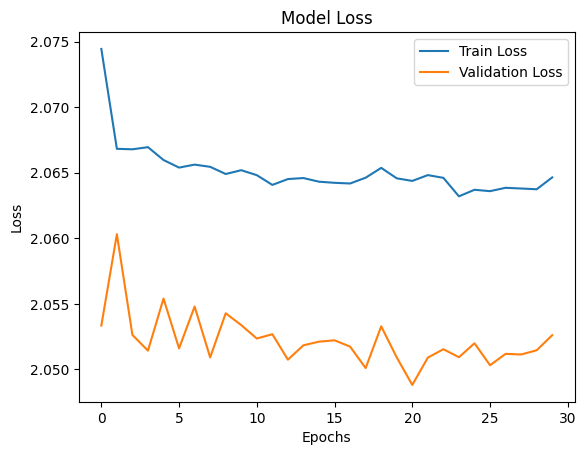

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpp4fttteq\assets


INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmpp4fttteq\assets


Saved artifact at 'C:\Users\admin\AppData\Local\Temp\tmpp4fttteq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 59, 1), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1681985217424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985217808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985218000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985218960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985219152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985219728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985219920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985220496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985220112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1681985220688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  168198521

ConverterError: Variable constant folding is failed. Please consider using enabling `experimental_enable_resource_variables` flag in the TFLite converter object. For example, converter.experimental_enable_resource_variables = True<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "functional_1_1/lstm_1_1/TensorArrayV2_1@__inference_function_25578"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_25657"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: loc(callsite(callsite(fused["TensorListReserve:", "functional_1_1/lstm_1_1/TensorArrayV2_1@__inference_function_25578"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_25657"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [9]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# **Step 1: Data Preprocessing**
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/"

def extract_features(file_path):
    """Extract audio features (MFCCs, Chroma, Spectral Contrast)."""
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def parse_emotion_from_filename(filename):
    """Extract emotion label from filename and map to zero-based indexing."""
    parts = filename.split('-')
    emotion_code = int(parts[2])  # Extract emotion code
    return emotion_code - 1  # Convert to zero-based index

# Process all actor folders
data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features is not None:
                    label = parse_emotion_from_filename(file)
                    data.append((features, label))

# Create DataFrame
features_df = pd.DataFrame(data, columns=["features", "label"])

# Convert features and labels into arrays
X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# **Step 2: Define the Model**
def build_transformer_lstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking()(inputs)

    # Transformer Encoder
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=False)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
num_classes = len(np.unique(y))  # Number of unique emotion labels
input_shape = (X_train.shape[1], 1)
model = build_transformer_lstm(input_shape, num_classes)

model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()

# **Step 3: Train the Model**
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

# **Step 4: Evaluate the Model**
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# **Step 5: Visualize Training Progress**
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# **Step 6: Save the Model**
model.save("emotion_classification_model.h5")

# Convert to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("emotion_classification_model.tflite", "wb") as f:
    f.write(tflite_model)


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# **Step 1: Data Preprocessing**
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/"

def extract_features(file_path):
    """Extract audio features (MFCCs, Chroma, Spectral Contrast)."""
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def parse_emotion_from_filename(filename):
    """Extract emotion label from filename and map to zero-based indexing."""
    parts = filename.split('-')
    emotion_code = int(parts[2])  # Extract emotion code
    return emotion_code - 1  # Convert to zero-based index

# Generate synthetic confidence scores
def generate_confidence(label):
    """Generate synthetic confidence scores based on the emotion label."""
    # For simplicity, assign higher confidence to certain labels (mock data)
    confidence_map = {0: 0.9, 1: 0.8, 2: 0.85, 3: 0.7, 4: 0.95, 5: 0.75, 6: 0.88, 7: 0.92}
    return confidence_map.get(label, 0.8)

# Process all actor folders
data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features is not None:
                    label = parse_emotion_from_filename(file)
                    confidence = generate_confidence(label)
                    data.append((features, label, confidence))

# Create DataFrame
features_df = pd.DataFrame(data, columns=["features", "label", "confidence"])

# Convert features and labels into arrays
X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())
confidence = np.array(features_df["confidence"].tolist())

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp, conf_train, conf_temp = train_test_split(
    X, y, confidence, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, conf_val, conf_test = train_test_split(
    X_temp, y_temp, conf_temp, test_size=0.5, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape confidence values to match model output
conf_train = conf_train.reshape(-1, 1)  # Reshape to [batch_size, 1]
conf_val = conf_val.reshape(-1, 1)
conf_test = conf_test.reshape(-1, 1)

# **Step 2: Define the Model**
def build_transformer_lstm_with_confidence(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking()(inputs)

    # Transformer Encoder
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=False)(x)

    # Outputs
    emotion_output = layers.Dense(num_classes, activation="softmax", name="emotion_output")(x)
    confidence_output = layers.Dense(1, activation="sigmoid", name="confidence_output")(x)

    model = models.Model(inputs, [emotion_output, confidence_output])
    return model

# Build and compile the model
num_classes = len(np.unique(y))  # Number of unique emotion labels
input_shape = (X_train.shape[1], 1)
model = build_transformer_lstm_with_confidence(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mse"
    },
    metrics={
        "emotion_output": "accuracy"
    }
)

model.summary()

# **Step 3: Train the Model**
history = model.fit(
    X_train, {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)

# **Step 4: Evaluate the Model**
test_loss, test_metrics = model.evaluate(
    X_test, {"emotion_output": y_test, "confidence_output": conf_test}, verbose=1)
print(f"Test Emotion Accuracy: {test_metrics['emotion_output_accuracy'] * 100:.2f}%")
print(f"Test Confidence MSE: {test_loss['confidence_output']:.4f}")

# **Step 5: Visualize Training Progress**
# Accuracy Plot
plt.plot(history.history['emotion_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_emotion_output_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Emotion Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# **Step 6: Save the Model**
model.save("emotion_confidence_model.h5")

# Convert to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("emotion_confidence_model.tflite", "wb") as f:
    f.write(tflite_model)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_1 (NotEqual)        │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_1 (Masking)           │ (None, 59, 1)             │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_1 (Any)                   │ (None, 59)                │               0 │ not_equal_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 59, 1)             │             897 │ masking_1[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ masking_1[0][0],           │
│                               │                           │                 │ any_1[0][0], any_1[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 59, 1)             │               2 │ multi_head_attention_1[0]… │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 59, 64)            │             128 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ (None, 128)               │          98,816 │ dense_1[0][0], any_1[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emotion_output (Dense)        │ (None, 8)                 │           1,032 │ lstm_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ confidence_output (Dense)     │ (None, 1)                 │             129 │ lstm_1[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 101,004 (394.55 KB)

 Trainable params: 101,004 (394.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_6080\2914167263.py", line 120, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 2 5 5 3 7 4 3 6 5 2 5 4 6 7 6 0 3 2 2 2 3 2 6 2 7 1 2 1 1 3 1 4
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_11470]

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# **Step 1: Data Preprocessing**
DATA_PATH = "C:/Users/admin/Desktop/Voice Expression Detection Model1/Giggle_Function_2/"

def extract_features(file_path):
    """Extract audio features (MFCCs, Chroma, Spectral Contrast)."""
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        return np.hstack([mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def parse_emotion_from_filename(filename):
    """Extract emotion label from filename and map to zero-based indexing."""
    parts = filename.split('-')
    emotion_code = int(parts[2])  # Extract emotion code
    return emotion_code - 1  # Map to zero-based index

# Generate synthetic confidence scores
def generate_confidence(label):
    """Generate synthetic confidence scores based on the emotion label."""
    confidence_map = {0: 0.9, 1: 0.8, 2: 0.85, 3: 0.7, 4: 0.95, 5: 0.75, 6: 0.88, 7: 0.92}
    return confidence_map.get(label, 0.8)

# Process all actor folders
data = []
for actor_folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, actor_folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                if features is not None:
                    label = parse_emotion_from_filename(file)
                    confidence = generate_confidence(label)
                    data.append((features, label, confidence))

# Create DataFrame
features_df = pd.DataFrame(data, columns=["features", "label", "confidence"])

# Convert features and labels into arrays
X = np.array(features_df["features"].tolist())
y = np.array(features_df["label"].tolist())
confidence = np.array(features_df["confidence"].tolist())

# Verify and assert label correctness
num_classes = len(np.unique(y))
print(f"Unique labels in the dataset: {np.unique(y)}")
assert np.all((y >= 0) & (y < num_classes)), "Labels must be in range [0, num_classes - 1]"

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp, conf_train, conf_temp = train_test_split(
    X, y, confidence, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, conf_val, conf_test = train_test_split(
    X_temp, y_temp, conf_temp, test_size=0.5, random_state=42)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape confidence values to match model output
conf_train = conf_train.reshape(-1, 1)  # Reshape to [batch_size, 1]
conf_val = conf_val.reshape(-1, 1)
conf_test = conf_test.reshape(-1, 1)

# **Step 2: Define the Model**
def build_transformer_lstm_with_confidence(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Masking()(inputs)

    # Transformer Encoder
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation="relu")(x)

    # LSTM Layer
    x = layers.LSTM(128, return_sequences=False)(x)

    # Outputs
    emotion_output = layers.Dense(num_classes, activation="softmax", name="emotion_output")(x)
    confidence_output = layers.Dense(1, activation="sigmoid", name="confidence_output")(x)

    model = models.Model(inputs, [emotion_output, confidence_output])
    return model

# Build and compile the model
input_shape = (X_train.shape[1], 1)
model = build_transformer_lstm_with_confidence(input_shape, num_classes)

model.compile(
    optimizer="adam",
    loss={
        "emotion_output": "sparse_categorical_crossentropy",
        "confidence_output": "mse"
    },
    metrics={
        "emotion_output": "accuracy"
    }
)

model.summary()

# **Step 3: Train the Model**
history = model.fit(
    X_train, {"emotion_output": y_train, "confidence_output": conf_train},
    validation_data=(X_val, {"emotion_output": y_val, "confidence_output": conf_val}),
    epochs=30,
    batch_size=32,
    verbose=1
)

# **Step 4: Evaluate the Model**
test_loss, test_metrics = model.evaluate(
    X_test, {"emotion_output": y_test, "confidence_output": conf_test}, verbose=1)
print(f"Test Emotion Accuracy: {test_metrics['emotion_output_accuracy'] * 100:.2f}%")
print(f"Test Confidence MSE: {test_loss['confidence_output']:.4f}")

# **Step 5: Visualize Training Progress**
# Accuracy Plot
plt.plot(history.history['emotion_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_emotion_output_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Emotion Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# **Step 6: Save the Model**
model.save("emotion_confidence_model.h5")

# Convert to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("emotion_confidence_model.tflite", "wb") as f:
    f.write(tflite_model)


Unique labels in the dataset: [0 1 2 3 4 5 6 7]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 59, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 59, 1)             │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 59)                │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 59, 1)             │             897 │ masking[0][0],             │
│ (MultiHeadAttention)          │                           │                 │ masking[0][0], any[0][0],  │
│                               │                           │                 │ any[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 59, 1)             │               2 │ multi_head_attention[0][0] │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 59, 64)            │             128 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 128)               │          98,816 │ dense[0][0], any[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ emotion_output (Dense)        │ (None, 8)                 │           1,032 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ confidence_output (Dense)     │ (None, 1)                 │             129 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 101,004 (394.55 KB)

 Trainable params: 101,004 (394.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. D

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\admin\AppData\Local\Temp\ipykernel_18552\1663889057.py", line 123, in <module>

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 7 which is outside the valid range of [0, 1).  Label values: 4 2 5 2 1 2 1 1 5 4 6 4 7 5 5 3 2 2 3 5 5 5 6 0 0 6 1 0 2 3 3 4
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_5735]